**Packages**

In [35]:
import numpy as np
import pandas as pd
import math
import seaborn as sn

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer, normalize


import os

import scipy

**Helper Functions**

In [9]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [10]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

In [11]:
def plot_f1_macro(history):
    plt.plot(history.history['f1_macro'], label='train_f1')
    plt.plot(history.history['val_f1_macro'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1_macro']),
                max(history.history['val_f1_macro'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.title('Macro F1 Score')
    plt.legend()
    plt.grid(True)

In [12]:
def plot_f1_weighted(history):
    plt.plot(history.history['f1_weighted'], label='train_f1')
    plt.plot(history.history['val_f1_weighted'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1_weighted']),
                max(history.history['val_f1_weighted'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Weighted F1 Score')
    plt.title('Weighted F1 Score')
    plt.legend()
    plt.grid(True)

In [13]:
# FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x1 = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x2 = make_layer(x1, 128, blocks_per_layer[1], stride=2, name='layer2')
    x3 = make_layer(x2, 256, blocks_per_layer[2], stride=2, name='layer3')
    x4 = make_layer(x3, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x4)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

**Data Pre-Processing**

Pulling in Train and Test Sets

In [14]:
tiles_train = pd.read_csv(r'./Data/Tiles_TRAIN.csv')
#x_train = tiles_train.drop(['bins_numeric'], axis = 1)
#y_train = tiles_train['bins_numeric']
#x_train.head(5)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(tiles_train.drop(['bins_numeric'], axis = 1), tiles_train['bins_numeric'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)
x_train.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
1762,1526,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4603,11426,0.0,7.0,0.0,8.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6484,13993,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6950,3201,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4254,13779,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
x_val.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
2732,2948,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
630,2945,4.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2887,7123,1.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,12171,0.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8106,1096,2.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
tiles_test = pd.read_csv(r'./Data/Tiles_TEST.csv')
x_test = tiles_test.drop(['Tile_ID','bins_numeric'], axis = 1)
y_test = tiles_test['bins_numeric']
x_test.head(5)

,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,94101,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,0.0,3.0,6.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Image Pre-Processing

In [18]:
# TRAIN SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [19]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(6700, 148, 188, 4)

In [20]:
x_train = x_train.drop(['Tile_ID'], axis = 1)

In [21]:
# VAL SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part15(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_val['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
#     images_mini = normalize(images_mini.reshape(6700,-1))
    
    return images_mini

In [22]:
images_mini_v = preprocess_data_part15(IMAGE_PATH)
np.shape(images_mini_v)

(1676, 148, 188, 4)

In [23]:
x_val = x_val.drop(['Tile_ID'], axis = 1)

In [24]:
# TEST SET

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in tiles_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [25]:
images_mini_t = preprocess_data_part2(IMAGE_PATH)
np.shape(images_mini_t)

(2095, 148, 188, 4)

Street Data Pre-Processing

In [26]:
# TRAIN SET 

street = np.asarray(x_train).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(6700, 1, 1, 39)

In [27]:
# VAL SET 

street_v = np.asarray(x_val).astype('float32')
street_mini_v = []
for row in range(len(street_v)):
    street_mini_v.append([[street_v[row]]])
street_mini_v = np.stack(street_mini_v)
np.shape(street_mini_v)

(1676, 1, 1, 39)

In [28]:
# TEST SET 

street_t = np.asarray(x_test).astype('float32')
street_mini_t = []
for row in range(len(street_t)):
    street_mini_t.append([[street_t[row]]])
street_mini_t = np.stack(street_mini_t)
np.shape(street_mini_t)

(2095, 1, 1, 39)

**Modeling**

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

**Model 2.7.0: Resnet = 1000 classes, checkpoint added, 40 epochs, LR scheduler added**

In [29]:
check = pd.DataFrame({'bins': y_train, 'ones': np.ones(len(y_train))}, columns=['bins', 'ones'])
pivot = check.pivot_table(index=['bins'], values=['ones'], aggfunc=len)
print(pivot)

      ones
bins      
0     5297
1      108
2      968
3      230
4       22
5        4
6       53
7       11
8        3
9        1
10       3


In [30]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.11498790052688486,
 1: 5.63973063973064,
 2: 0.6292261457550714,
 3: 2.6482213438735176,
 4: 27.68595041322314,
 5: 152.27272727272728,
 6: 11.492281303602057,
 7: 55.37190082644628,
 8: 203.03030303030303,
 9: 609.0909090909091,
 10: 203.03030303030303}

In [39]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((53, 93), strides=1)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1_m = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1_macro',
    )

f1_w = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'weighted',
    threshold = None,
    name = 'f1_weighted',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning rate defined by scheduler
    loss='categorical_crossentropy',
    metrics = ['accuracy', keras.metrics.Precision(), f1_m, f1_w])

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

# define the checkpoint
filepath = "model.7"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1_weighted', verbose=1, save_best_only=True, mode='max')
callbacks_check = checkpoint

def scheduler(epoch, lr):
    if epoch <= 6:
        return 0.0001
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = cnn_model.fit(
    [images_mini, street_mini],
    y_t,
    epochs=40,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_v], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weights,
    callbacks=[callback, callbacks_check],
    )

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 147, 187, 39  663         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 95, 95, 39)  0           ['conv2d_4[0][0]']               
                                                                                            

2023-04-01 08:00:56.805708: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2982732800 exceeds 10% of free system memory.


210/210 [==============================] - ETA: 0s - loss: 4.0966 - accuracy: 0.5221 - precision_4: 0.5170 - f1_macro: 0.1142 - f1_weighted: 0.6193 
Epoch 1: val_f1_weighted improved from -inf to 0.72465, saving model to model.7


INFO:tensorflow:Assets written to: model.7/assets


INFO:tensorflow:Assets written to: model.7/assets


210/210 [==============================] - 7545s 36s/step - loss: 4.0966 - accuracy: 0.5221 - precision_4: 0.5170 - f1_macro: 0.1142 - f1_weighted: 0.6193 - val_loss: 1.3702 - val_accuracy: 0.6754 - val_precision_4: 0.7006 - val_f1_macro: 0.1145 - val_f1_weighted: 0.7247 - lr: 1.0000e-04
Epoch 2/40
210/210 [==============================] - ETA: 0s - loss: 2.4574 - accuracy: 0.6200 - precision_4: 0.8749 - f1_macro: 0.1263 - f1_weighted: 0.6851 
Epoch 2: val_f1_weighted did not improve from 0.72465
210/210 [==============================] - 7514s 36s/step - loss: 2.4574 - accuracy: 0.6200 - precision_4: 0.8749 - f1_macro: 0.1263 - f1_weighted: 0.6851 - val_loss: 0.9529 - val_accuracy: 0.6748 - val_precision_4: 0.8170 - val_f1_macro: 0.1121 - val_f1_weighted: 0.7244 - lr: 1.0000e-04
Epoch 3/40
210/210 [==============================] - ETA: 0s - loss: 2.2251 - accuracy: 0.6199 - precision_4: 0.8820 - f1_macro: 0.1281 - f1_weighted: 0.6835 
Epoch 3: val_f1_weighted improved from 0.72465 t

INFO:tensorflow:Assets written to: model.7/assets


INFO:tensorflow:Assets written to: model.7/assets


210/210 [==============================] - 7492s 36s/step - loss: 2.2251 - accuracy: 0.6199 - precision_4: 0.8820 - f1_macro: 0.1281 - f1_weighted: 0.6835 - val_loss: 0.9626 - val_accuracy: 0.6784 - val_precision_4: 0.9321 - val_f1_macro: 0.1248 - val_f1_weighted: 0.7271 - lr: 1.0000e-04
Epoch 4/40
210/210 [==============================] - ETA: 0s - loss: 2.0603 - accuracy: 0.6210 - precision_4: 0.8817 - f1_macro: 0.1475 - f1_weighted: 0.6832 
Epoch 4: val_f1_weighted did not improve from 0.72710
210/210 [==============================] - 7489s 36s/step - loss: 2.0603 - accuracy: 0.6210 - precision_4: 0.8817 - f1_macro: 0.1475 - f1_weighted: 0.6832 - val_loss: 0.9417 - val_accuracy: 0.6587 - val_precision_4: 0.8255 - val_f1_macro: 0.1394 - val_f1_weighted: 0.7116 - lr: 1.0000e-04
Epoch 5/40
210/210 [==============================] - ETA: 0s - loss: 2.0943 - accuracy: 0.6240 - precision_4: 0.8538 - f1_macro: 0.1332 - f1_weighted: 0.6849 
Epoch 5: val_f1_weighted did not improve from 0.

In [70]:
# saving last epoch model just in case 
cnn_model.save('model.7.last.epoch')

INFO:tensorflow:Assets written to: model.7.last.epoch/assets


INFO:tensorflow:Assets written to: model.7.last.epoch/assets


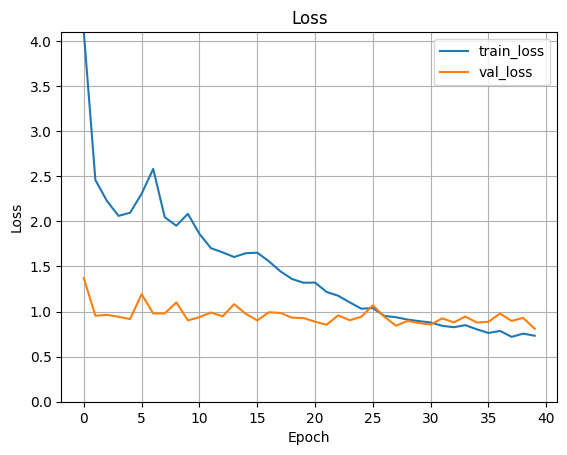

In [40]:
plot_loss(history)

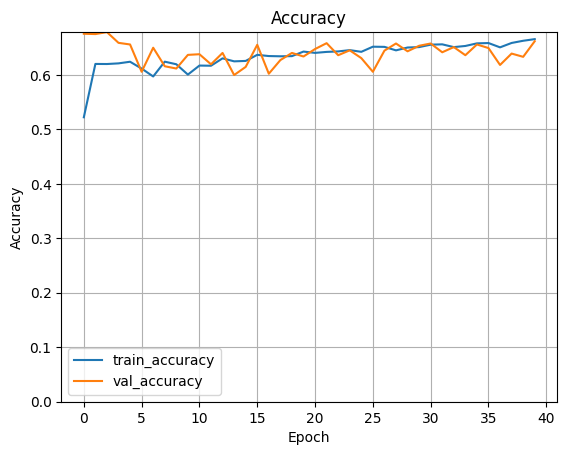

In [41]:
plot_accuracy(history)

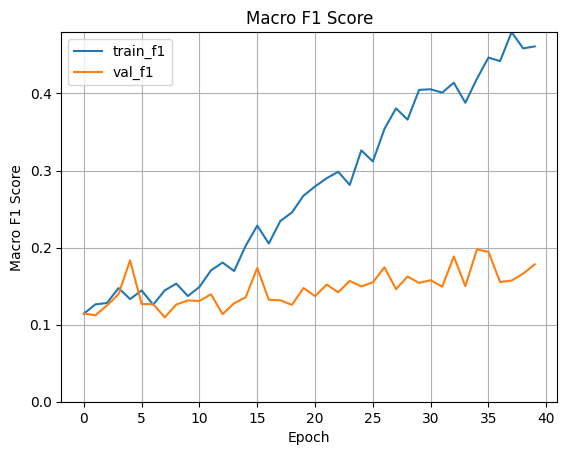

In [42]:
plot_f1_macro(history)

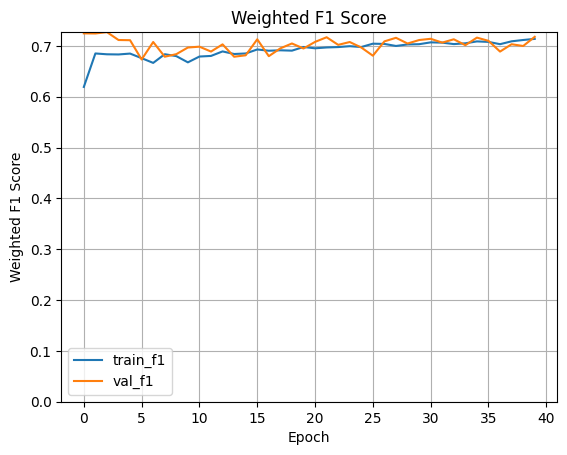

In [43]:
plot_f1_weighted(history)

In [44]:
y_pred2 = cnn_model.predict([images_mini_v, street_mini_v])
y_pred2

53/53 [==============================] - 176s 3s/step


array([[8.7016654e-01, 2.9670779e-04, 1.2680526e-01, ..., 7.6116500e-08,
        2.4497457e-08, 4.2532542e-09],
       [1.1885654e-01, 2.2036409e-01, 3.9165938e-01, ..., 3.7344691e-06,
        1.3978787e-06, 3.4417358e-06],
       [4.4498163e-01, 6.8918359e-03, 3.7003165e-01, ..., 1.0877694e-09,
        8.9649843e-10, 1.6062267e-10],
       ...,
       [9.6034311e-02, 1.8614118e-01, 2.9213229e-01, ..., 1.2859802e-05,
        2.6477612e-06, 4.9820874e-06],
       [4.2565140e-01, 3.6009767e-03, 5.0844014e-01, ..., 1.2857320e-08,
        5.4459388e-09, 7.3907874e-10],
       [4.0738615e-01, 1.9824957e-03, 5.4166198e-01, ..., 2.3310454e-09,
        5.3524279e-10, 1.3849274e-11]], dtype=float32)

In [45]:
pred_values2 = []
for i in y_pred2: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values2.append(index[0])
pred_values2[0:5]

[0, 2, 0, 2, 2]

In [46]:
y_true = list(y_val)
y_true[0:5]

[0, 0, 0, 0, 0]

<Axes: title={'center': 'Confusion Matrix'}>

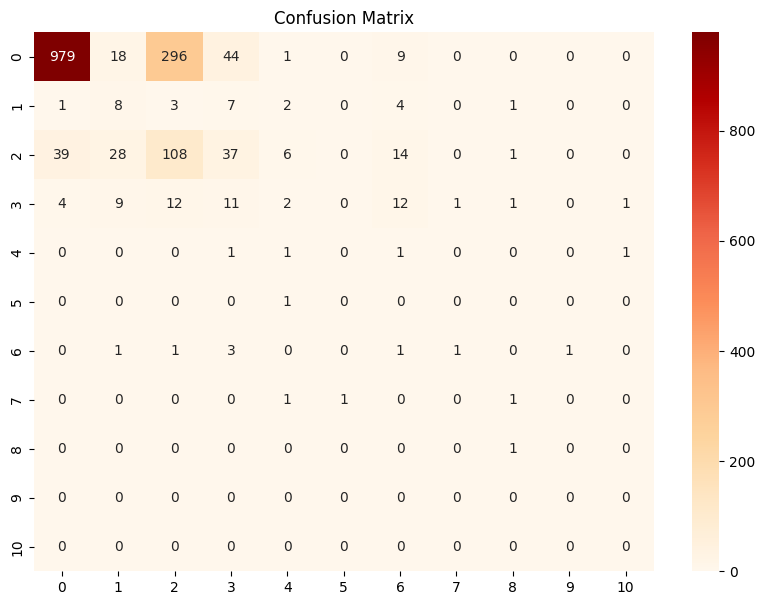

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values2)
ind = max(len(np.unique(y_true)), len(np.unique(pred_values2)))
df_cm = pd.DataFrame(cm, index = [i for i in range(ind)],
                  columns = [i for i in range(ind)])
df_cm
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
sn.heatmap(df_cm, annot=True, fmt='.3g',cmap="OrRd")

**Loading best model from checkpoint**

In [49]:
# load the model
filepath = "model.7"
new_model = load_model(filepath)
# assert_allclose(cnn_model.predict([images_mini_v, street_mini_v]),
#                 new_model.predict([images_mini_v, street_mini_v]),
#                 1e-5)

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [58]:
y_pred3 = new_model.predict([images_mini_t, street_mini_t])
y_pred3

66/66 [==============================] - 220s 3s/step


array([[7.43737280e-01, 1.54302083e-02, 1.30869642e-01, ...,
        2.97136791e-03, 2.61581875e-03, 1.50423194e-03],
       [4.50630598e-02, 1.33527756e-01, 7.83499926e-02, ...,
        1.12025529e-01, 4.79565039e-02, 2.84340885e-02],
       [8.05384874e-01, 9.46980901e-03, 1.02466926e-01, ...,
        9.67240951e-04, 6.13187300e-03, 4.08363109e-03],
       ...,
       [8.30544710e-01, 8.52881465e-03, 1.01439528e-01, ...,
        9.03779408e-04, 6.99748634e-04, 4.17101663e-04],
       [6.79256737e-01, 2.47456115e-02, 1.37389228e-01, ...,
        6.67757122e-03, 5.20958193e-03, 3.04659735e-03],
       [5.22683740e-01, 3.44802961e-02, 2.05614969e-01, ...,
        6.83330745e-03, 3.87097965e-03, 2.65677343e-03]], dtype=float32)

In [59]:
pred_values3 = []
for i in y_pred3: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values3.append(index[0])
pred_values3[0:5]

[0, 3, 0, 0, 0]

In [62]:
y_true = list(y_test)
y_true[0:5]

[0, 4, 0, 0, 0]

In [64]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values3)
ind = max(len(np.unique(y_true)), len(np.unique(pred_values3)))
df_cm = pd.DataFrame(cm, index = [i for i in range(11)],
                  columns = [i for i in range(11)])
df_cm
# plt.figure(figsize = (10,7))
# plt.title('Confusion Matrix')
# plt.ylabel('Actual Values')
# plt.xlabel('Predicted Values')
# sn.heatmap(df_cm, annot=True, fmt='.3g',cmap="OrRd")

,0,1,2,3,4,5,6,7,8,9,10
0,1233,0,299,81,2,0,14,0,7,3,7
1,3,0,4,19,2,0,0,0,11,1,3
2,68,1,123,83,3,0,6,0,15,2,3
3,8,0,17,34,0,0,1,0,5,4,3
4,0,0,0,1,2,0,0,0,2,0,5
5,0,0,0,0,0,0,0,0,0,0,2
6,0,0,0,5,1,0,1,0,1,0,3
7,0,0,0,1,0,0,0,0,1,0,2
8,0,0,0,0,0,0,0,0,0,0,2
9,0,0,0,0,0,0,0,0,0,0,1


In [66]:
import sklearn
sklearn.metrics.f1_score(y_true, pred_values3, average='weighted')

0.7119535946246566

In [67]:
sklearn.metrics.f1_score(y_true, pred_values3, average='macro')

0.1503022235460378

In [68]:
sklearn.metrics.f1_score(y_true, pred_values3, average=None)

array([0.8336714 , 0.        , 0.32931727, 0.22972973, 0.2       ,
       0.        , 0.06060606, 0.        , 0.        , 0.        ,
       0.        ])